<h1 style="background-color: #428bca; color:#FFFFFF">1 - Import packages & Load Libraries<a id=a></a></h1>

In [1]:
!pip install opencv-python

In [2]:
# Making all necessary imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print(tf.__version__)

2.4.1


In [3]:
def get_files(base_dir, target_dir):
    count = 0
    path = get_path(base_dir, target_dir)
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            count+=len(glob.glob(os.path.join(dirname, filename)))
        return path, count

def get_path(base_dir, target_dir):
    path = os.path.join(base_dir,target_dir)
    return path

<h1 style="background-color: #428bca; color:#FFFFFF">2 - Data exploration<a id=b></a></h1>

**Dataset analysis is a necessary step before creating models**

**3 folders are provided to us:** 
```
Dataset/
	test/
		opacity/
		normal/
	train/
		opacity/
		normal/
    val/
		opacity/
		normal/
```

<h2 style="background-color: #8db6cd; color:#FFFFFF">2.1 - Directory Setup for Train-validation-test <a id=ba></a></h2>

In [4]:
base_dir = 'D:/Machine Proj/Project/Dataset'

train_normal_dir = 'D:/Machine Proj/Project/Dataset/train/normal'
train_pneumonia_dir = 'D:/Machine Proj/Project/Dataset/train/opacity'

val_normal_dir = 'D:/Machine Proj/Project/Dataset/val/normal'
val_pneumonia_dir = 'D:/Machine Proj/Project/Dataset/val/opacity'

test_normal_dir = 'D:/Machine Proj/Project/Dataset/test/normal'
test_pneumonia_dir = 'D:/Machine Proj/Project/Dataset/test/opacity'


train_normal_path, train_normal_count = get_files(base_dir,train_normal_dir)
train_pneumonia_path, train_pneumonia_count = get_files(base_dir,train_pneumonia_dir)

val_normal_path, val_normal_count = get_files(base_dir,val_normal_dir)
val_pneumonia_path, val_pneumonia_count = get_files(base_dir,val_pneumonia_dir)

test_normal_path, test_normal_count = get_files(base_dir,test_normal_dir)
test_pneumonia_path, test_pneumonia_count = get_files(base_dir,test_pneumonia_dir)

print("No of Train Images: {}".format(train_normal_count + train_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(train_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(train_pneumonia_count))

print("No of Validation Images: {}".format(val_normal_count + val_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(val_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(val_pneumonia_count))

print("No of Test Images: {}".format(test_normal_count + test_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(test_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(test_pneumonia_count))


No of Train Images: 4192
 • No of Normal Images 1082
 • No of Pneumonia Images 3110
No of Validation Images: 1040
 • No of Normal Images 267
 • No of Pneumonia Images 773
No of Test Images: 624
 • No of Normal Images 234
 • No of Pneumonia Images 390


In [5]:
train_data = []
for filename in os.listdir(train_normal_path):
    train_data.append((os.path.join(train_normal_path,filename),0))

for filename in os.listdir(train_pneumonia_path):
    train_data.append((os.path.join(train_pneumonia_path,filename),1))

train_data = pd.DataFrame(train_data, columns=['image_path', 'label'], index=None)
train_data = train_data.sample(frac=1).reset_index(drop=True)
        
val_data = []
for filename in os.listdir(val_normal_path):
    val_data.append((os.path.join(val_normal_path,filename),0))

for filename in os.listdir(val_pneumonia_path):
    val_data.append((os.path.join(val_pneumonia_path,filename),1))
        
val_data = pd.DataFrame(val_data, columns=['image_path', 'label'], index=None)
        
test_data = []
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))

for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))

test_data = pd.DataFrame(test_data, columns=['image_path', 'label'], index=None)

print("Train Data {}".format(train_data.shape))
print("Validation Data {}".format(val_data.shape))
print("Test Data {}".format(test_data.shape))

Train Data (4192, 2)
Validation Data (1040, 2)
Test Data (624, 2)


In [6]:
train_data

,image_path,label
0,../input/pneumonia-xray-images/train/opacity/p...,1
1,../input/pneumonia-xray-images/train/opacity/p...,1
2,../input/pneumonia-xray-images/train/opacity/p...,1
3,../input/pneumonia-xray-images/train/normal/IM...,0
4,../input/pneumonia-xray-images/train/opacity/p...,1
...,...,...
4187,../input/pneumonia-xray-images/train/opacity/p...,1
4188,../input/pneumonia-xray-images/train/opacity/p...,1
4189,../input/pneumonia-xray-images/train/opacity/p...,1
4190,../input/pneumonia-xray-images/train/normal/IM...,0


<AxesSubplot:>

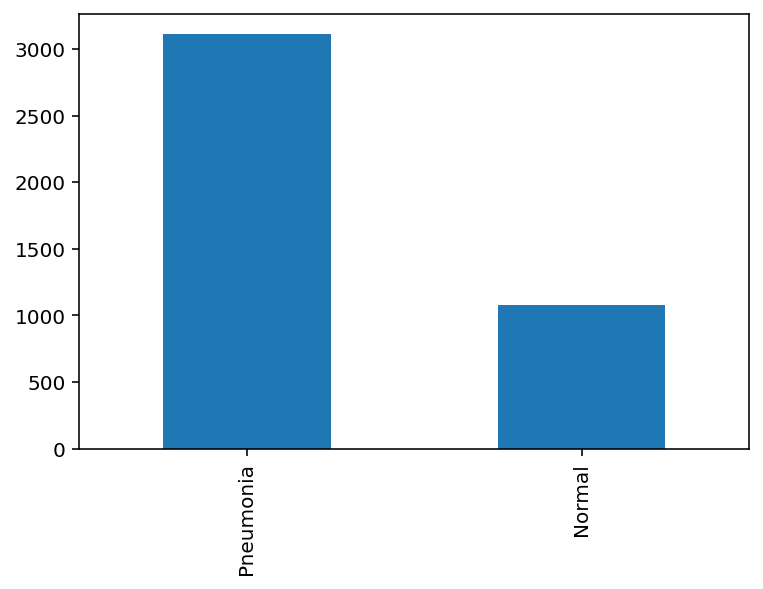

In [7]:
class_dict = {0:'Normal', 1:'Pneumonia'}
train_data['class_name'] = train_data.label.map(class_dict)
train_data['class_name'].value_counts().plot(kind='bar')

In [9]:
for filepath in train_data.image_path:
    image = cv2.imread(filepath)
    image_size = image.shape
    break
image_size

(1006, 1404, 3)

<h2 style="background-color: #8db6cd; color:#FFFFFF">2.2 - Visualization <a id=bb></a></h2>

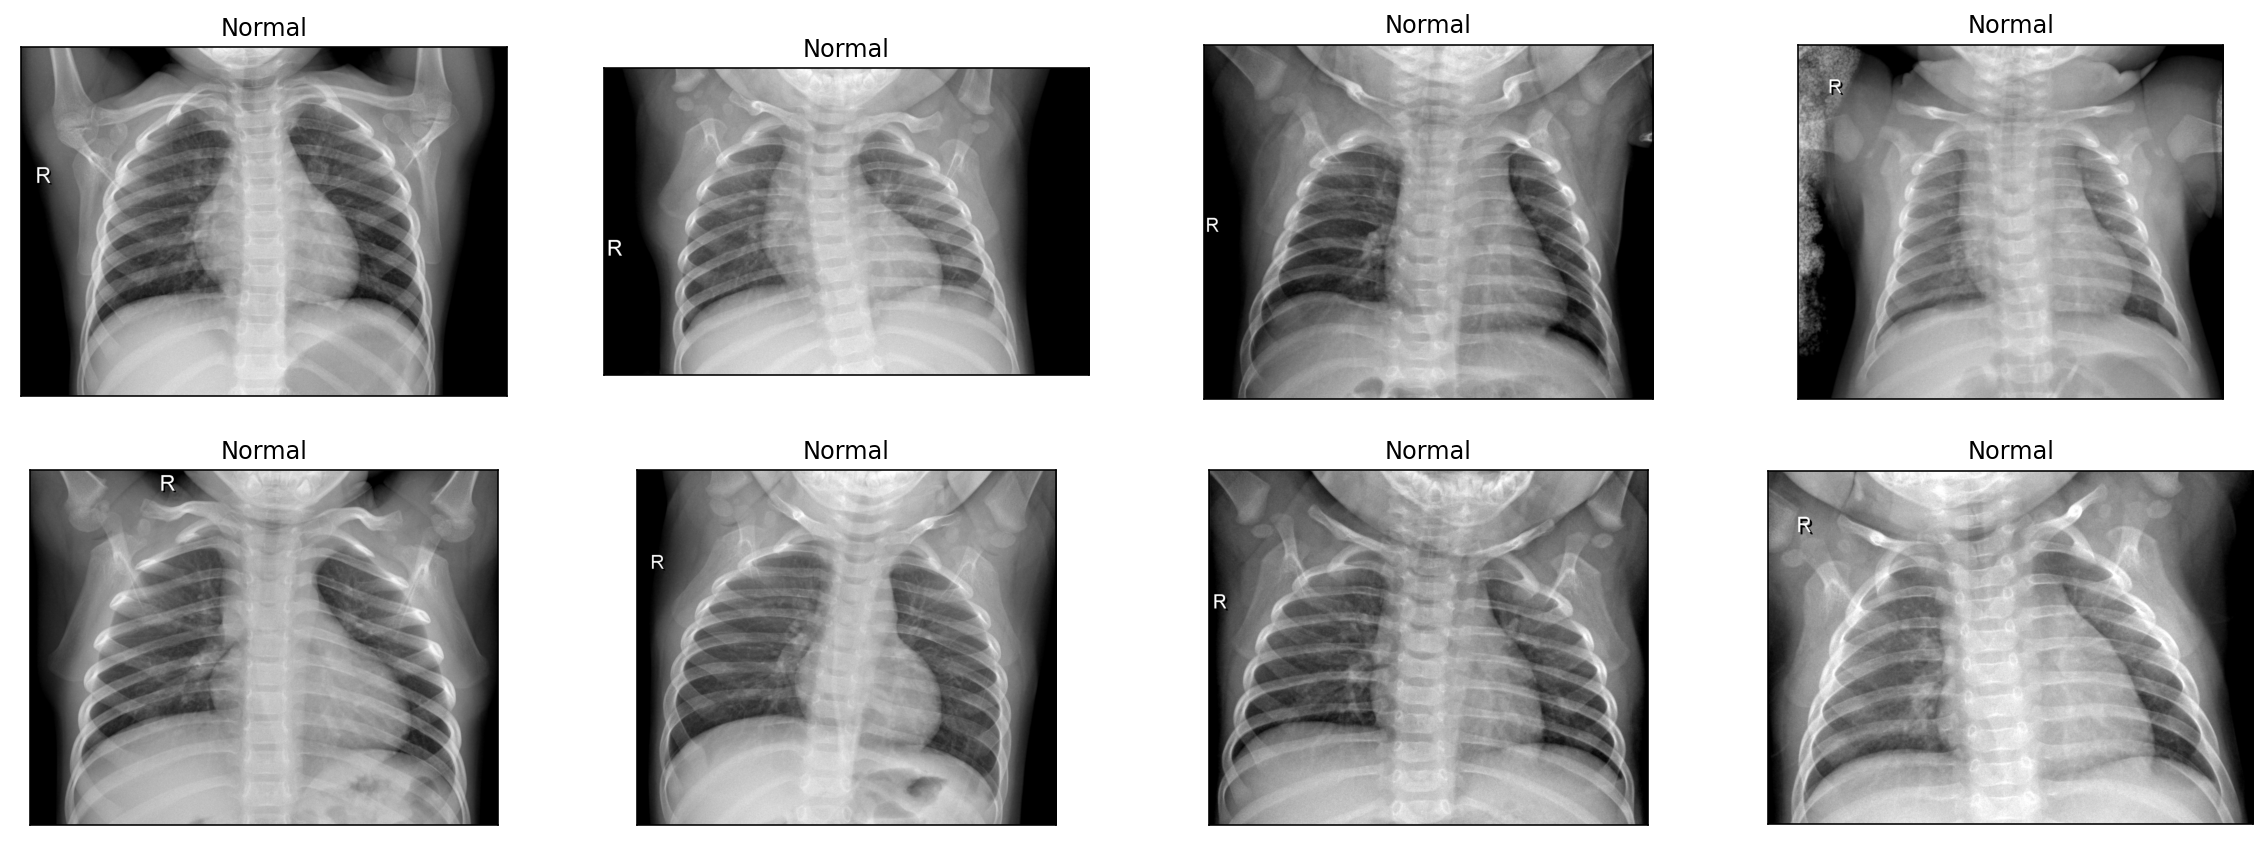

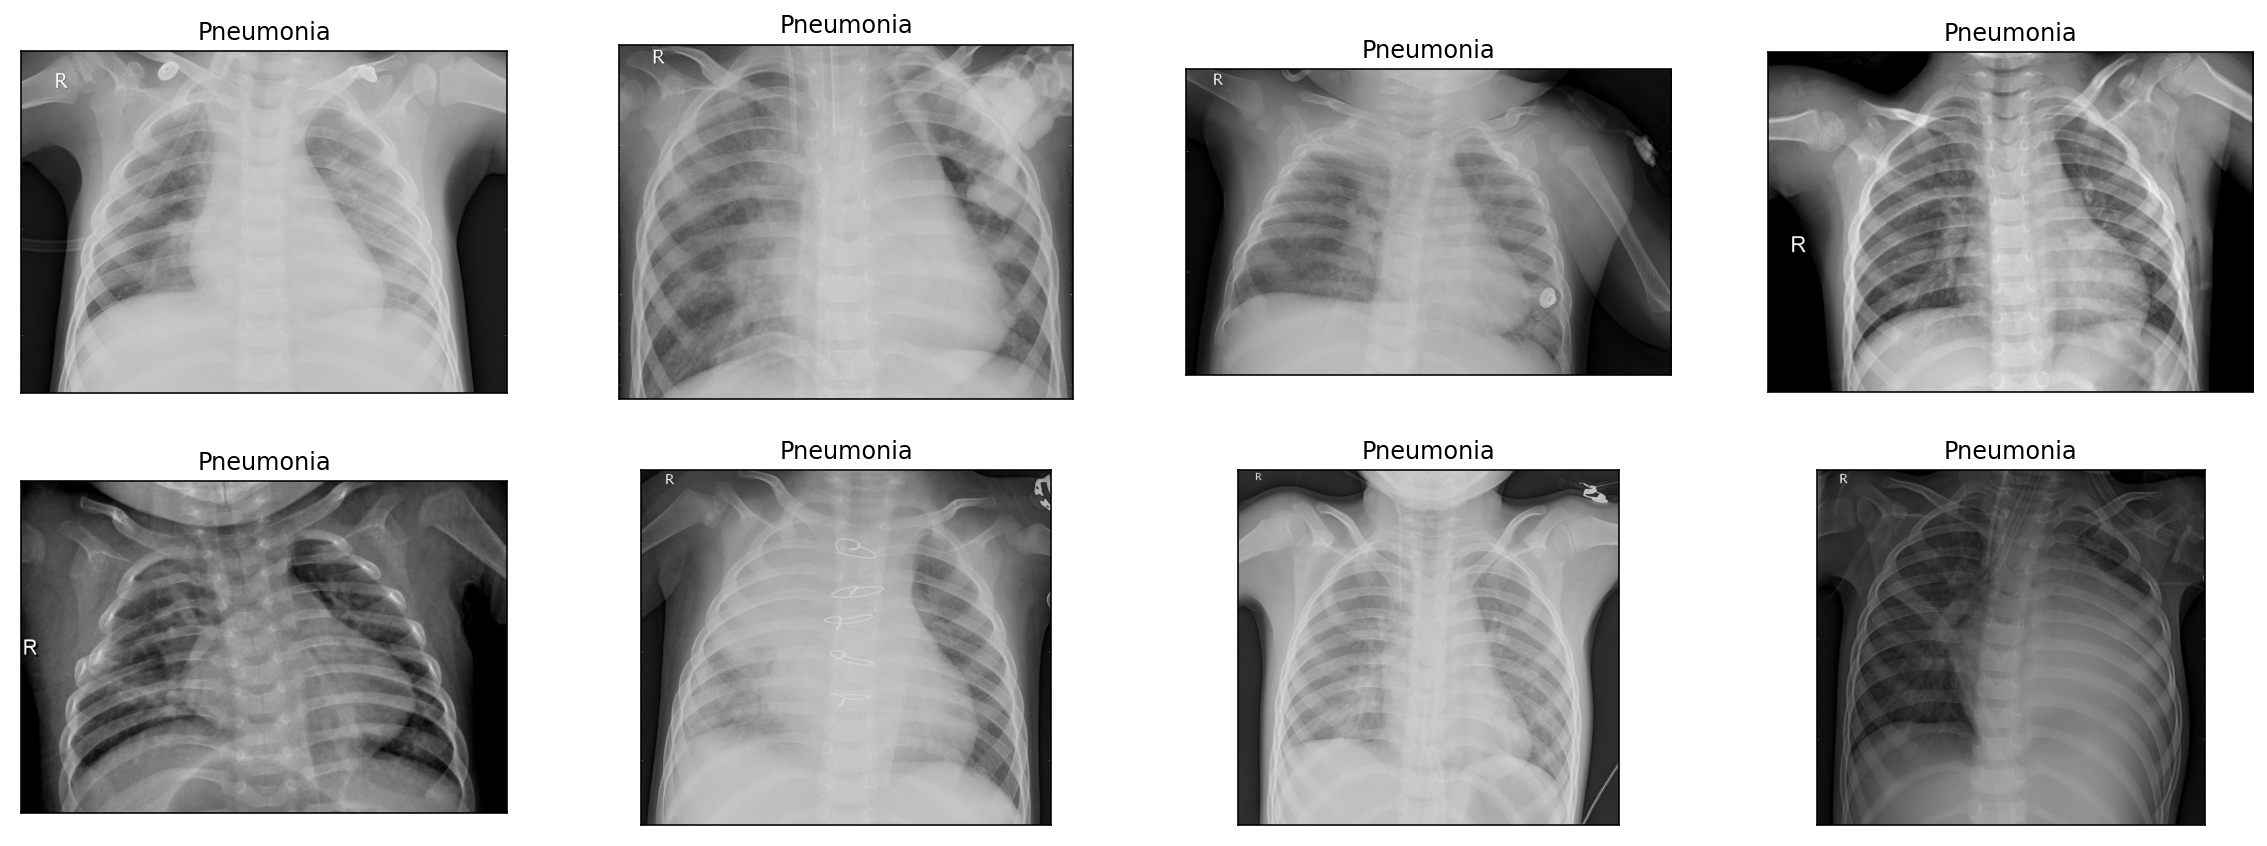

In [10]:
def visualize_img(images):
    fig = plt.figure(figsize=(20, 15))
    for i,path in enumerate(images):
        fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        img = cv2.imread(path)
        plt.imshow(img)
        plt.title(train_data[train_data.image_path == path].class_name.values[0])
        
for i in range(2):
    images = train_data[train_data.label == i].image_path
    images = np.random.choice(images , 8)
    visualize_img(images)

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

<h1 style="background-color: #428bca; color:#FFFFFF">3 - Data Augmentation <a id=c></a></h1>

In [12]:
BATCH_SIZE = 32
IMG_SHAPE  = 224

train_image_gen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=[0.2,1.0],
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col='class_name',
                                              class_mode='binary',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))

Found 4192 validated image filenames belonging to 2 classes.


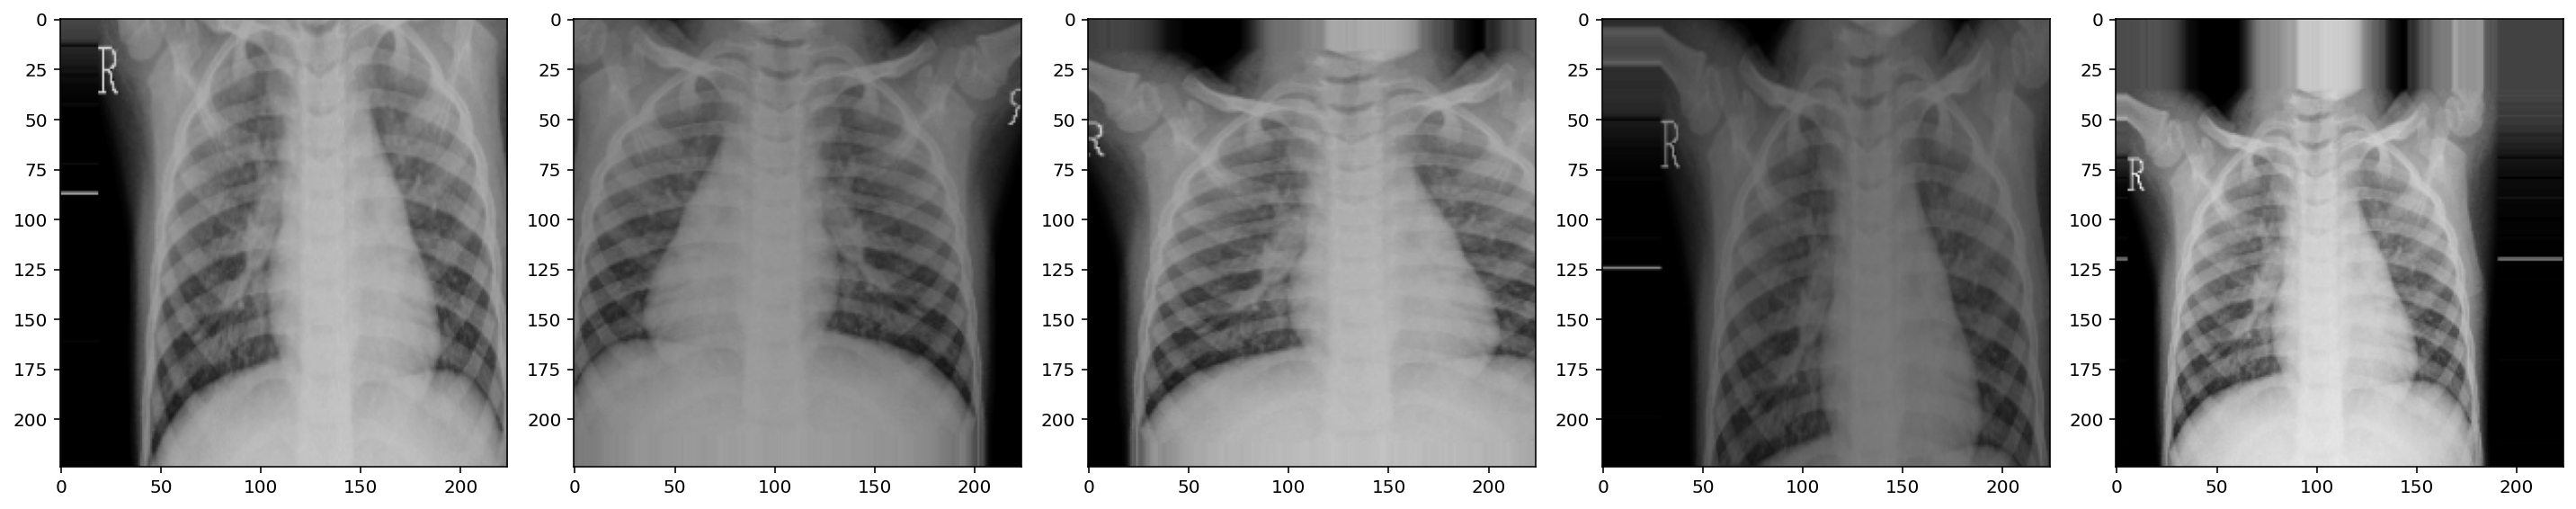

In [23]:
augmented_images = [train_gen[0][0][2] for i in range(5)]
plotImages(augmented_images)

<h1 style="background-color: #428bca; color:#FFFFFF">4 - Data Preprocessing <a id=d></a></h1>

In [24]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

train_lb = to_categorical(train_data.label, dtype = int)
val_lb = to_categorical(val_data.label, dtype=int)

train_data = train_data.reset_index().drop(labels='index', axis=1)
y_train = pd.DataFrame(train_lb).add_prefix('label_')

val_data = val_data.reset_index().drop(labels='index', axis=1)
y_val = pd.DataFrame(val_lb).add_prefix('label_')

train_data = pd.concat([train_data, y_train], axis=1)
val_data = pd.concat([val_data, y_val], axis=1)

print("Training set has {} samples".format(train_data.shape[0]))
print("Validation set has {} samples".format(val_data.shape[0]))

Training set has 4192 samples
Validation set has 1040 samples


<h2 style="background-color: #8db6cd; color:#FFFFFF">4.1 - Helper Functions <a id=da></a></h2>

In [25]:
BATCH_SIZE = 32
IMG_SHAPE  = 224
EPOCHS = 20

def gen():
    train_image_gen = ImageDataGenerator(rescale=1./255,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         brightness_range=[0.2,1.0],
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest')

    train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col=[f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))


    val_image_gen = ImageDataGenerator(rescale=1./255)

    val_gen = val_image_gen.flow_from_dataframe(val_data,
                                              x_col='image_path',
                                              y_col= [f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))
    return train_gen, val_gen


In [26]:
def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [27]:
from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = tf.cast(image , tf.float32)
    image = tf.image.resize(image , (224 , 224))
    image = image/255
    image = image.numpy()
    return image

<h1 style="background-color: #428bca; color:#FFFFFF">5 - Model Building <a id=e></a></h1>

<h2 style="background-color: #8db6cd; color:#FFFFFF">5.3 - DenseNet169 <a id=dd></a></h2>

In [48]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

base = DenseNet169(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable =  False

densenet_model = Sequential()
densenet_model.add(base)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(2, activation='softmax'))

densenet_model.summary()

51879936/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________

In [52]:
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
densenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              restore_best_weights=True)

model_save = ModelCheckpoint('./densenet169.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


dense_history = densenet_model.fit(train_gen,
                              steps_per_epoch = train_gen.samples // BATCH_SIZE,
                              epochs = EPOCHS,
                              validation_data = val_gen,
                              callbacks=[EarlyStopping, model_save])

Found 4192 validated image filenames.
Found 1040 validated image filenames.
Epoch 1/20
131/131 [==============================] - 109s 768ms/step - loss: 0.8379 - accuracy: 0.5811 - val_loss: 0.4822 - val_accuracy: 0.8596

Epoch 00001: val_loss improved from inf to 0.48221, saving model to ./densenet169.h5
Epoch 2/20
131/131 [==============================] - 99s 755ms/step - loss: 0.4852 - accuracy: 0.8235 - val_loss: 0.2789 - val_accuracy: 0.9337

Epoch 00002: val_loss improved from 0.48221 to 0.27895, saving model to ./densenet169.h5
Epoch 3/20
131/131 [==============================] - 98s 743ms/step - loss: 0.3651 - accuracy: 0.8727 - val_loss: 0.2052 - val_accuracy: 0.9452

Epoch 00003: val_loss improved from 0.27895 to 0.20515, saving model to ./densenet169.h5
Epoch 4/20
131/131 [==============================] - 97s 744ms/step - loss: 0.3211 - accuracy: 0.8859 - val_loss: 0.1630 - val_accuracy: 0.9529

Epoch 00004: val_loss improved from 0.20515 to 0.16301, saving model to ./de

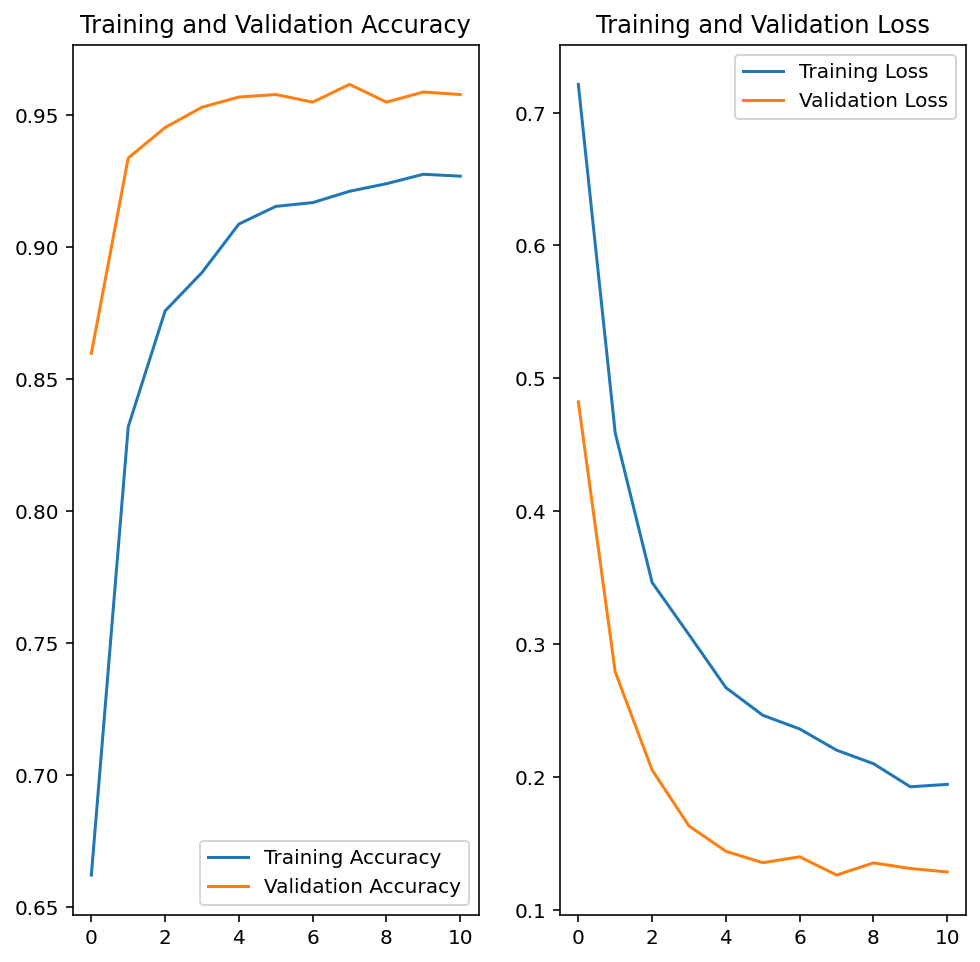

In [53]:
plot(dense_history)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       234
           1       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



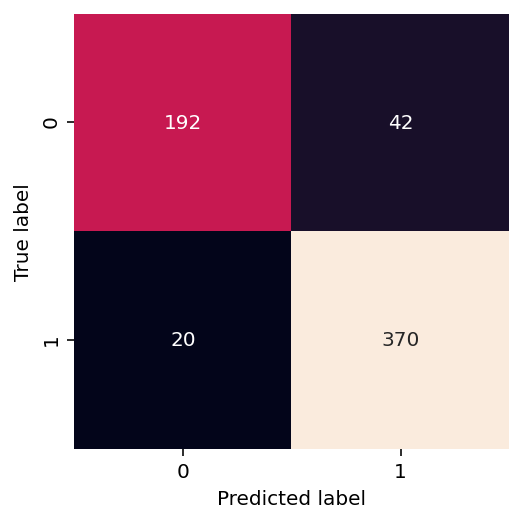

In [54]:
dense_pred =[]
for image in test_data.image_path:
    dense_pred.append(predict(image , densenet_model))
    
final_dense_pred  = np.argmax(dense_pred , axis=-1)
actual_label = test_data['label']

print(classification_report(actual_label, final_dense_pred))
matrix=confusion_matrix(actual_label, final_dense_pred)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');

In [55]:
print(dense_history.history['val_accuracy'][-4])
print(dense_history.history['val_loss'][-4])

0.9615384340286255
0.12605918943881989
